# Séquençage de l'ADN grâce au Machine Learning

*par Théo Gachet (Janvier 2023)*

# Introduction

Le génome est la collection de l'ADN d'un organisme. Tous les êtres vivants ont un génome mais la taille de ces derniers peut varier d'une espèce à l'autre. Par exemple, le génome humain comporte 23 chromosomes et chaque chromosome comporte environ 6 milliards de base azotées.

Chaque être humain a un génome unique qui lui est propre. Néanmoins, le génome de deux individus ne différe véritablement que d'environ 1%. Les génomes d'une même espèce sont donc en réalité très similaires.

L'utilisation du Machine Learning peut s'appliquer à la génomique en raison du très grand nombre de données exploitées, l'objectif étant de comprendre les liens entre les données pour déduire de nouvelles hypothèses.

Dans notre cas, nous chercherons à prédire l'influence de la variation génétique sur les mécanismes de régulation des gènes, comme la receptivité de l'ADN et l'épissage chez les cellules eucaryotes.

En particulier, nous allons comprendre comment interpréter la structure de l'ADN de manière à ce que ses informations soient utilisables par des algorithmes de Machine Learning afin de construire un modèle de prédiction basé sur les séquences d'ADN.

# Représentation d'une séquence ADN

L'ADN est une nucléotide composée de quatre types de bases azotées : Adénine (A), Cytosine (C), Guanine (G) et Thymine (T). Ce sont les liaisons hydrogènes qui assurent les liens entre ces composants chimiques en formant une chaîne.

L'ADN est le plus souvent représenté par une double hélice formée de deux chaînes. En effet, la deuxième chaîne s'obtient par complémentarité avec la première. Si la première chaîne contient un A (resp. C), alors dans la seconde vous aurez un T (resp. G) par symétrie. Ainsi, en identifiant une chaîne de l'hélice, on peut en déduire la seconde.

La séquence de l'ADN ,i.e. l'ordre des bases azotées, détermine les informations biologiques contenues dans un brin d'ADN. Par exemple, la séquence ATCGTT est le marqueur des yeux bleus et ATCGCT celui des yeux marrons.

# Librairie Biopython : outils computationnels de biologie moléculaire

In [1]:
from Bio import SeqIO

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [2]:
# un exemple de séquence ADN
for sequence in SeqIO.parse('data/dna-sequence-dataset/example_dna.fa', "fasta"):
    print("ID de la séquence :",sequence.id)
    print("Taille de la séquence :",len(sequence))
    print("-> [ {} ]".format(sequence.seq))
    break

ID de la séquence : ENST00000435737.5
Taille de la séquence : 390
-> [ ATGTTTCGCATCACCAACATTGAGTTTCTTCCCGAATACCGACAAAAGGAGTCCAGGGAATTTCTTTCAGTGTCACGGACTGTGCAGCAAGTGATAAACCTGGTTTATACAACATCTGCCTTCTCCAAATTTTATGAGCAGTCTGTTGTTGCAGATGTCAGCAACAACAAAGGCGGCCTCCTTGTCCACTTTTGGATTGTTTTTGTCATGCCACGTGCCAAAGGCCACATCTTCTGTGAAGACTGTGTTGCCGCCATCTTGAAGGACTCCATCCAGACAAGCATCATAAACCGGACCTCTGTGGGGAGCTTGCAGGGACTGGCTGTGGACATGGACTCTGTGGTACTAAATGAAGTCCTGGGGCTGACTCTCATTGTCTGGATTGACTGA ]


# Encodage des séquences ADN

Les données dont nous disposons sont sous la forme de chaînes de caractères. Pour qu'elles soient utilisables par un modèle de Machine Learning, nous devons les encoder sous la forme de matrices. Il existe pour cela plusieurs méthodes :

- l'encodage ordinal
- l'encodage "one-hot" (ou "1 parmi n")
- l'encodage par comptage de k-mer

## (1) L'encodage ordinal : on associe une valeur à chaque base azotée

In [3]:
def chaine_vers_tableau(sequence):
   sequence = sequence.lower()
   sequence = re.sub('[^acgt]', '', sequence)
   sequence = np.array(list(sequence))
   return sequence

# création d'un encodeur à label avec l'alphabet {a,c,g,t}
label_encoder = LabelEncoder()
label_encoder.fit(np.array(['a','c','g','t']))

LabelEncoder()

In [4]:
def enc_ordinal(tableau):
    entier_encode = label_encoder.transform(tableau)
    flottant_encode = entier_encode.astype(float)
    flottant_encode[flottant_encode == 0] = 0.25 # A
    flottant_encode[flottant_encode == 1] = 0.50 # C
    flottant_encode[flottant_encode == 2] = 0.75 # G
    flottant_encode[flottant_encode == 3] = 1.00 # T
    flottant_encode[flottant_encode == 4] = 0.00 # n'importe quelle autre lettre
    return flottant_encode

# testons le programme sur une courte séquence :
sequence_test = 'TTCAGCCAGTG'
enc_ordinal(chaine_vers_tableau(sequence_test))

array([1.  , 1.  , 0.5 , 0.25, 0.75, 0.5 , 0.5 , 0.25, 0.75, 1.  , 0.75])

## (2) L'encodage "one-hot" (ou "1 parmi n")

L'encodage "one-hot" (ou encodage "1 parmi n") consiste à encoder une variable à n états sur n bits dont un seul prend la valeur 1, le numéro du bit valant 1 étant le numéro de l'état pris par la variable.

Ainsi, "ATGC" devient [0,0,0,1], [0,0,1,0], [0,1,0,0], [1,0,0,0] et on pourra ensuite concaténer les vecteurs ou les transformer en tableaux à deux dimensions.

In [5]:
def enc_one_hot(chaine):
    entier_encode = label_encoder.transform(chaine)
    onehot_encodeur = OneHotEncoder(sparse=False, dtype=int)
    entier_encode = entier_encode.reshape(len(entier_encode), 1)
    onehot_encode = onehot_encodeur.fit_transform(entier_encode)
    onehot_encode = np.delete(onehot_encode, -1, 1)
    return onehot_encode

# testons le programme sur une courte séquence :
sequence_test = 'GAATTCTCGAA'
enc_one_hot(chaine_vers_tableau(sequence_test))

array([[0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 1, 0],
       [0, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0]])

## (3) L'encodage par comptage de k-mer 

Aucune des méthodes précédentes ne permet d'obtenir directement un vecteur de longueur uniforme (nécessaire pour les algorithmes de Machine Learning).

Voyons le génome comme un livre : les gènes sont des phrases, les chaînes d'acides aminés sont des mots et les acides et les bases de nucléotides forment l'alphabet. Suivant cette analogie, nous allons implémenter un algorithme de NLP (natural language processing), appelée "comptage de k-mer".

Ainsi, on prend une longue chaîne biologique que l'on divise en k-mer (chaînes de longueur k). Par exemple, si k=6, alors "ATGCATGCA" est divisé en quatre 6-mer (hexamer) : "ATGCAT", "TGCATG", "GCATGC", "CATGCA".

In [6]:
def kmers(sequence, k):
    return [sequence[indice:indice+k].upper() for indice in range(len(sequence) - k + 1)]

# testons le programme sur une courte séquence :
sequence_test = 'ATGCATGCA'
kmers(sequence_test,5)

['ATGCA', 'TGCAT', 'GCATG', 'CATGC', 'ATGCA']

On peut ensuite concaténer les k-mots en une phrase :

In [7]:
mots = kmers(sequence_test, 5)
phrase = ' '.join(mots)
phrase

'ATGCA TGCAT GCATG CATGC ATGCA'



You can tune both the word length and the amount of overlap. This allows you to determine how the DNA sequence information and vocabulary size will be important in your application. For example, if you use words of length 6, and there are 4 letters, you have a vocabulary of size 4096 possible words. You can then go on and create a bag-of-words model like you would in NLP.

Let’s make a couple more “sentences” to make it more interesting.

In [8]:
sequence1 = 'TCTCACACATGTGCCAATCACTGTCACCC'
sequence2 = 'GTGCCCAGGTTCAGTGAGTGACACAGGCAG'
phrase1 = ' '.join(kmers(sequence1, 6))
phrase2 = ' '.join(kmers(sequence2, 6))

In [10]:
# on construit ensuite le modèle de sac-de-mots
cv = CountVectorizer()
X = cv.fit_transform([phrase, phrase1, phrase2]).toarray()
X

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 0, 1]], dtype=int64)

# Contexte et objectifs du projet

Maintenant que nous savons comment extraire une matrice contenant les informations contenues dans une séquence d'ADN, on va pouvoir utiliser ces données et les appliquer dans le cadre du Machine Learning.

Notre objectif est de construire un modèle de classification qui prend des séquences d'ADN humain comme données d'entraînement et peut ensuite prédire la "famille" à laquelle appartient tel ou tel gène. Contrairement aux données d'entraînement, les données de test seront plus diversifiées et l'ADN pourra venir d'un humain, d'un chien ou d'un chimpanzé. On pourra alors étudier les conséquences de cette diversification génétique sur les performances du modèle.

La "famille" d'un gène est un groupe de gènes apparentés qui partagent un ancêtre en commun. Deux gènes d'une même famille peuvent être paralogues ou orthologues. Des gènes paralogues ont des séquences similaires au sein d'une même espèce tandis que des gènes paralogues ont des séquences similaires au sein d'espèces différentes.

# Chargement des séquences ADN

**ADN Humain**

In [11]:
adn_humain = pd.read_table('data/dna-sequence-dataset/human.txt')
adn_humain.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


Text(0.5, 1.0, "Distribution des classes dans l'ADN humain")

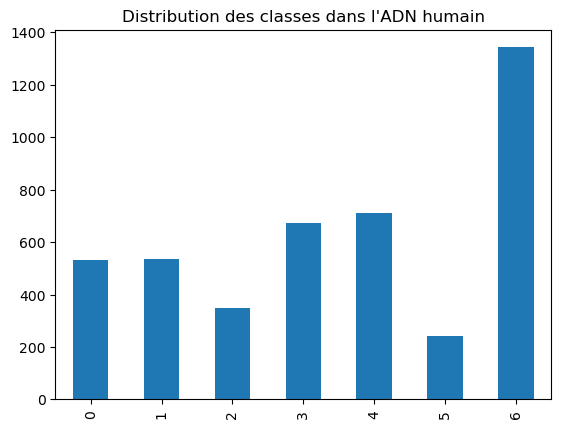

In [12]:
adn_humain['class'].value_counts().sort_index().plot.bar()
plt.title("Distribution des classes dans l'ADN humain")

**ADN de Chimpanzé**

In [13]:
adn_chimp = pd.read_table('data/dna-sequence-dataset/chimpanzee.txt')
adn_chimp.head()

,sequence,class
0,ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAG...,4
2,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
3,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
4,ATGGGCAGCGCCAGCCCGGGTCTGAGCAGCGTGTCCCCCAGCCACC...,6


Text(0.5, 1.0, "Distribution des classes dans l'ADN des chimpanzés")

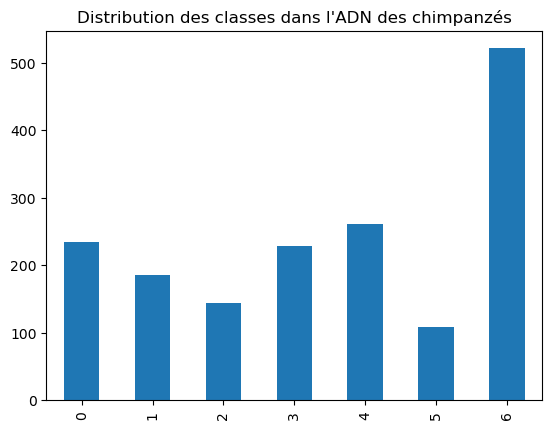

In [14]:
adn_chimp['class'].value_counts().sort_index().plot.bar()
plt.title("Distribution des classes dans l'ADN des chimpanzés")

**ADN de Chien**

In [15]:
adn_chien = pd.read_table('data/dna-sequence-dataset/dog.txt')
adn_chien.head()

,sequence,class
0,ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAA...,4
1,ATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAATAG...,4
2,ATGGAAACACCCTTCTACGGCGATGAGGCGCTGAGCGGCCTGGGCG...,6
3,ATGTGCACTAAAATGGAACAGCCCTTCTACCACGACGACTCATACG...,6
4,ATGAGCCGGCAGCTAAACAGAAGCCAGAACTGCTCCTTCAGTGACG...,0


Text(0.5, 1.0, "Distribution des classes dans l'ADN des chiens")

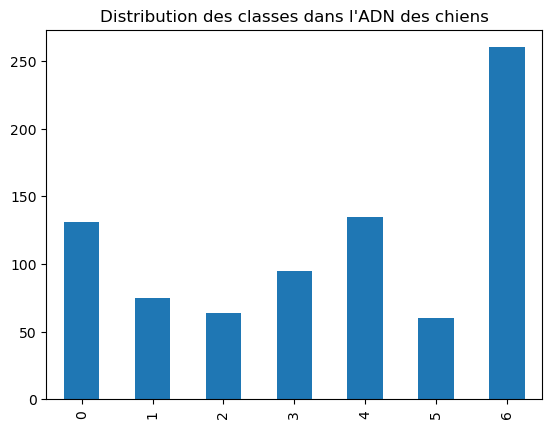

In [16]:
adn_chien['class'].value_counts().sort_index().plot.bar()
plt.title("Distribution des classes dans l'ADN des chiens")

Dans les bases de données de l'ADN humain, les 7 classes et leurs effectifs sont les suivantes :
- 0 : G protein couples receptors (nb = 531)
- 1 : Tyrosine kinase (nb = 534)
- 2 : Tyrosine phosphatase (nb = 349)
- 3 : Synthetase (nb = 672)
- 4 : Synthase (nb = 711)
- 5 : Ion channel (nb = 240)
- 6 : Transcription factor (nb = 1343)

# Collecte des hexamères

Maintenant que nos données sont chargées, l'étape suivante est de convertir une suite de caractères en mots k-mer, en particulier en hexamères (k=6). La fonction kmers() va collecter tous les k-mers possibles (avec chevauchement).

In [17]:
def kmers(seq, size=6):
    return [seq[x:x+size].upper() for x in range(len(seq) - size + 1)]

# nos séquences utilisées comme données d'entraînement sont converties en hexamères
# on applique ensuite le même procédé aux espèces différentes

adn_humain['words'] = adn_humain.apply(lambda x: kmers(x['sequence']), axis=1)
adn_humain = adn_humain.drop('sequence', axis=1)

adn_chimp['words'] = adn_chimp.apply(lambda x: kmers(x['sequence']), axis=1)
adn_chimp = adn_chimp.drop('sequence', axis=1)

adn_chien['words'] = adn_chien.apply(lambda x: kmers(x['sequence']), axis=1)
adn_chien = adn_chien.drop('sequence', axis=1)

# NB : recharger les données avant de ré-exécuter cette cellule deux fois de suite

In [18]:
adn_humain.head()

,class,words
0,4,"[ATGCCC, TGCCCC, GCCCCA, CCCCAA, CCCAAC, CCAAC..."
1,4,"[ATGAAC, TGAACG, GAACGA, AACGAA, ACGAAA, CGAAA..."
2,3,"[ATGTGT, TGTGTG, GTGTGG, TGTGGC, GTGGCA, TGGCA..."
3,3,"[ATGTGT, TGTGTG, GTGTGG, TGTGGC, GTGGCA, TGGCA..."
4,3,"[ATGCAA, TGCAAC, GCAACA, CAACAG, AACAGC, ACAGC..."


Nous avons désormais besoin, pour chaque gène, de convertir les listes d'hexamères en phrases de mots pour pouvoir créer le modèle "sac de mots" que nous souhaitons mettre en place. De plus, on va définir une variable y qui jouera le rôle de cible.

In [19]:
humain_texte = list(adn_humain['words'])
for i in range(len(humain_texte)):
    humain_texte[i] = ' '.join(humain_texte[i])

chimp_texte = list(adn_chimp['words'])
for i in range(len(chimp_texte)):
    chimp_texte[i] = ' '.join(chimp_texte[i])

chien_texte = list(adn_chien['words'])
for i in range(len(chien_texte)):
    chien_texte[i] = ' '.join(chien_texte[i])

# les labels sont séparés
y_humain = adn_humain.iloc[:, 0].values
y_chimp = adn_chimp.iloc[:, 0].values
y_chien = adn_chien.iloc[:, 0].values

In [20]:
y_humain

array([4, 4, 3, ..., 6, 6, 6], dtype=int64)

La variable cible contient ainsi un tableau de classes.

On va ensuite utiliser le "sac de mots" via CountVectorizer(), c'est l'équivalent du comptage de k-mer. Par défaut, on utilisera des n-grammes (sous-séquences de n éléments) et on va convertir nos k-mers en vecteurs numériques de longueur uniforme dont le rôle sera de représenter le compte de chacun des k-mers.

In [21]:
cv = CountVectorizer(ngram_range=(4,4))
X_humain = cv.fit_transform(humain_texte)
X_chimp = cv.transform(chimp_texte)
X_chien = cv.transform(chien_texte)

In [23]:
print("Pour les humains, on a {} gènes convertis en vectors de taille uniforme pour le comptage des hexamères 4-grammes.\n".format(X_humain.shape[0]))
print("Pour les chimpanzés, on a {} gènes convertis en vectors de taille uniforme pour le comptage des hexamères 4-grammes\n".format(X_chimp.shape[0]))
print("Pour les chiens, on a {} gènes convertis en vectors de taille uniforme pour le comptage des hexamères 4-grammes.".format(X_chien.shape[0]))

Pour les humains, on a 4380 gènes convertis en vectors de taille uniforme pour le comptage des hexamères 4-grammes.

Pour les chimpanzés, on a 1682 gènes convertis en vectors de taille uniforme pour le comptage des hexamères 4-grammes

Pour les chiens, on a 820 gènes convertis en vectors de taille uniforme pour le comptage des hexamères 4-grammes.


Maintenant que l'on sait comment transformer les séquences d'ADN en vecteurs numériques de longueur uniforme pour le comptage des k-mers et n-grammes, nous pouvons désormais aller plus loin et concevoir un modèle de classification qui prédit la fonction d'une séquence d'ADN en fonction de cette même séquence.

Nous n'utiliserons que de l'ADN humain pour entraîner le modèle, avec 20% de l'ADN humain utilisé comme données de test. L'objectif est d'avoir un modèle généralisé, donc on pourra appliquer le modèle sur de l'ADN issu d'espèces différentes (ici de chimpanzés et de chiens).

On construit donc un modèle de classification naïve bayésienne (naïve car on suppose une forte indépendance des hypothèses).

**NB :** Pour observer des fluctuations et optimiser le modèle, on pourra faire varier les paramètres et construire des modèles avec différentes tailles de n-grammes et différentes valeurs pour alpha.

In [24]:
# on sépare les données d'ADN humain en sous-ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_humain, y_humain, test_size = 0.20, random_state=42)

On va créer un classifieur naïf bayésien et multinomial. Après plusieurs essais, les valeurs les plus optimisées la taille des n-grammes est 4, et alpha = 0.1

In [25]:
classifieur = MultinomialNB(alpha=0.1)
classifieur.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

# Prédictions sur les données de test

In [26]:
y_pred = classifieur.predict(X_test)

On veut étudier les performances du modèle donc on va s'intéresser en détail à plusieurs métriques : la précision (bonnes prédictions parmi toutes les prédictions sélectionnées), le rappel (bonnes prédictions parmi toutes les prédictions sélectionnables), l'exactitude (accuracy), le score F1 (moyenne harmonique entre la précision et le rappel) ainsi que la matrice de confusion.

In [27]:
print("Matrice de confusion pour des prédictions sur des séquences d'ADN humain :\n")
print(pd.crosstab(pd.Series(y_test, name='Réalité'), pd.Series(y_pred, name='Prédiction')))

def métriques(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = métriques(y_test, y_pred)

print("\nexactitude = {} \nprécision  = {} \nrappel     = {} \nscore F1   = {}".format(accuracy, precision, recall, f1))

Matrice de confusion pour des prédictions sur des séquences d'ADN humain :

Prédiction   0    1   2    3    4   5    6
Réalité                                   
0           99    0   0    0    1   0    2
1            0  104   0    0    0   0    2
2            0    0  78    0    0   0    0
3            0    0   0  124    0   0    1
4            1    0   0    0  143   0    5
5            0    0   0    0    0  51    0
6            1    0   0    1    0   0  263

exactitude = 0.9840182648401826 
précision  = 0.984290543482443 
rappel     = 0.9840182648401826 
score F1   = 0.9840270014702487


On a testé le modèle sur de l'ADN humain alors qu'il avait appris sur de l'ADN humain. On a logiquement obtenu de très bons résultats. Maintenant, mettons notre modèle à l'épreuve en le confrontant à de l'ADN d'autres espèces (chimpanzés et chiens).

D'abord, l'ADN de chimpanzés. On s'attend à ce que ça fonctionne bien car le chimpanzé et l'homme sont très proches biologiquement puisqu'ils partagent un ancêtre commun.

In [28]:
y_pred_chimp = classifieur.predict(X_chimp)

In [31]:
print("Matrice de confusion pour des prédictions sur des séquences d'ADN de chimpanzés :\n")
print(pd.crosstab(pd.Series(y_chimp, name='Réalité'), pd.Series(y_pred_chimp, name='Prédiction')))

accuracy, precision, recall, f1 = métriques(y_chimp, y_pred_chimp)

print("\nexactitude = {} \nprécision  = {} \nrappel     = {} \nscore F1   = {}".format(accuracy, precision, recall, f1))

Matrice de confusion pour des prédictions sur des séquences d'ADN de chimpanzés :

Prédiction    0    1    2    3    4    5    6
Réalité                                      
0           232    0    0    0    0    0    2
1             0  184    0    0    0    0    1
2             0    0  144    0    0    0    0
3             0    0    0  227    0    0    1
4             2    0    0    0  254    0    5
5             0    0    0    0    0  109    0
6             0    0    0    0    0    0  521

exactitude = 0.9934601664684899 
précision  = 0.993551028649631 
rappel     = 0.9934601664684899 
score F1   = 0.993453334125236


Désormais, testons le modèle sur de l'AND de chien, on s'attend à des performances moins bonnes.

In [32]:
y_pred_chien = classifieur.predict(X_chien)

In [33]:
print("Matrice de confusion pour des prédictions sur des séquences d'ADN de chiens :\n")
print(pd.crosstab(pd.Series(y_chien, name='Actual'), pd.Series(y_pred_chien, name='Predicted')))

accuracy, precision, recall, f1 = métriques(y_chien, y_pred_chien)

print("\nexactitude = {} \nprécision  = {} \nrappel     = {} \nscore F1   = {}".format(accuracy, precision, recall, f1))

Matrice de confusion pour des prédictions sur des séquences d'ADN de chiens :

Predicted    0   1   2   3    4   5    6
Actual                                  
0          127   0   0   0    0   0    4
1            0  63   0   0    1   0   11
2            0   0  49   0    1   0   14
3            1   0   0  81    2   0   11
4            4   0   0   1  126   0    4
5            4   0   0   0    1  53    2
6            0   0   0   0    0   0  260

exactitude = 0.925609756097561 
précision  = 0.9340667154775472 
rappel     = 0.925609756097561 
score F1   = 0.9251228556957126


**Observations :** Comme prévu, le modèle produit de très bons résultats sur l'ADN humain et sur celui des chimpanzés, qui partagent un ancêtre commun avec l'homme. En revanche, le modèle a plus de mal à classifier l'ADN chez les espèces génétiquement éloignées de l'homme.